# ADVANCED PSE+ STAKEHOLDER SUMMIT I 2023: 
# Interactive Code Demonstration Using WaterTAP

### Today's demonstration will show 
- Part 1: how to build, initialize, simulate, and optimize a flowsheet for multiperiod analysis. The demonstration will demonstrate the use of a reverse osmosis (RO) unit model.
- Part 2: :
    - Public Github Repository: https://github.com/watertap-org/watertap
    - Documentation: https://watertap.readthedocs.io/en/stable/
    - Installer for User Interface: https://watertap-org.github.io/

# Overall approach to multiperiod flowsheets
<p align="center">
  <img src="assets/MP_Framework.png" height="320">
</p>

## Part 1: Build, setup, and simulate the multiperiod RO+PV+Battery flowsheet


<p align="center">
  <img src="assets/RO_PV_Batt.svg">
</p>

## Multiperiod Setup

### Quick and high-level overview of setting up steady-state and surrogate parts
#### Import Pyomo, IDAES, and WaterTAP packages

In [1]:
# Pyomo imports
from pyomo.environ import ConcreteModel, Objective, Var, value, units as pyunits

# IDAES imports
from idaes.core import FlowsheetBlock
from idaes.apps.grid_integration.multiperiod.multiperiod import MultiPeriodModel
from idaes.core.solvers.get_solver import get_solver


#### Build Model

In [2]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

#### Import and define the Reverse Osmosis unit model

In [3]:
from steady_state_flowsheets.simple_RO_unit import ROUnit
m.fs.RO = ROUnit()

#### This simple RO unit will assume a steady-state system with constant production and power demand
        ROUnit.product = 6000 # m3/day
        ROUnit.power_demand = 944.3 # kW

#### Import and define the Battery model

In [4]:
from steady_state_flowsheets.battery import BatteryStorage
m.fs.battery = BatteryStorage()


#### The battery model will have some of the following attributes
| Var                       | Descr                                     | Unit |
| :----:                    | :----:                                    |:----:|
| nameplate_power           | Nameplate power of battery energy storage | kW   |
| nameplate_energy          | Nameplate energy of battery energy storage| kWh  |
| initial_state_of_charge   | State of charge at t - 1                  | kWh  |
| elec_in                   | Energy in                                 | kWh  |
| elec_out                  | Energy out                                | kWh  |
| state_of_charge           | State of charge at t                      | kWh  |

#### Load PV surrogate
<p align="center">
  <img src="assets/solar_cycle.png" width="380">
</p>

##### The PV surrogate will predict the energy production of a given PV system based on:
* PV system design size [kW] (peak power )
* Day of the year
* Hour of the Day

In [5]:
from idaes.core.surrogate.pysmo_surrogate import PysmoSurrogate
PV_surrogate = PysmoSurrogate.load_from_file('assets/demo_surrogate.json')

2023-10-06 16:04:19 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Default parameter estimation method is used.

Parameter estimation method:  algebraic
Gaussian basis function is used.
Basis function:  gaussian
Regularization done:  True


### Define critical variables and add energy balance constraints

In [6]:
from steady_state_flowsheets.system import *
define_system_vars(m)
add_steady_state_constraints(m)

#### System-level variables include:
| Var                       | Descr                                     | Unit |
| :----:                    | :----:                                    |:----:|
| pv_to_ro           | Energy supplied to the RO coming from PV | kW  |
| grid_to_ro          | Energy supplied to the RO coming from grid | kW |
| curtailment   | PV curtailment                 | kWh |
| elec_price                   | Electricity Price                                 | kWh  |
| pv_gen                   | Energy in                                 | $/kWh  |

### The steady state constraints:

*pv_gen = pv_to_ro + elec_in + curtailment*

*ROUnit.power_demand = pv_to_ro + battery.elec_out + grid_to_ro*

#### Add Table Here

In [7]:
solver = get_solver()
m.fs.battery.initialize()
results = solver.solve(m)

2023-10-06 16:04:20 [INFO] idaes.init.fs.battery: Battery initialization status optimal - Optimal Solution Found.


In [8]:
for v in m.fs.component_data_objects(ctype=Var, active=True, descend_into=True):
        print(f'{str(v):<40s}', f'{value(v):<10,.1f}', pyunits.get_units(v))

fs.pv_to_ro                              333.2      kW
fs.grid_to_ro                            333.4      kW
fs.curtailment                           84,007.0   kW
fs.elec_price                            0.1        USD_2021
fs.elec_generation                       1,000.0    kW
fs.pv_gen                                151,077.3  kW
fs.ro_elec_req                           1,000.0    kW
fs.electricity_price                     0.1        USD_2021
fs.battery.nameplate_power               178,215.7  kW
fs.battery.nameplate_energy              305,965.0  kWh
fs.battery.initial_state_of_charge       94,603.2   kWh
fs.battery.initial_energy_throughput     85,328.7   kWh
fs.battery.elec_in[0.0]                  66,737.1   kWh
fs.battery.elec_out[0.0]                 333.4      kWh
fs.battery.state_of_charge[0.0]          157,652.6  kWh
fs.battery.energy_throughput[0.0]        118,863.9  kWh


### Create a Pyomo concrete model and steady-state flowsheet

## Refresh - approach to multiperiod flowsheets
<p align="center">
  <img src="assets/MP_Framework_2.png" height="380">
</p>

In [9]:
def get_pv_ro_variable_pairs(t1, t2):
    """
    This function returns pairs of variables that need to be connected across two time periods

    Args:
        t1: current time block
        t2: next time block

    Returns:
        None
    """
    return [
        (t1.fs.battery.state_of_charge[0], t2.fs.battery.initial_state_of_charge),
        (t1.fs.battery.energy_throughput[0], t2.fs.battery.initial_energy_throughput),
        (t1.fs.battery.nameplate_power, t2.fs.battery.nameplate_power),
        (t1.fs.battery.nameplate_energy, t2.fs.battery.nameplate_energy),
        ]

#### Define the flowsheet options

In [10]:
def create_multiperiod_pv_battery_model(
        n_time_points= 24,
        ro_capacity = 6000, # m3/day
        ro_elec_req = 1000, # kW
        pv_oversize = 1,
        surrogate = None):
    
    mp = MultiPeriodModel(
        n_time_points=n_time_points,
        process_model_func= steady_state_flowsheet,
        linking_variable_func= get_pv_ro_variable_pairs,
        initialization_func= m.fs.battery.initialize(),
        unfix_dof_func= unfix_dof,
    )
    
    flowsheet_options={ t: { 
                            "pv_gen": eval_surrogate(surrogate, design_size = 1000, Day = 1, Hour = t%24),
                            "electricity_price": get_elec_tier(Hour = t%24),
                            "ro_capacity": ro_capacity, 
                            "ro_elec_req": ro_elec_req,
                            "pv_oversize": pv_oversize} 
                            for t in range(n_time_points)
    }

    # create the multiperiod object
    mp.build_multi_period_model(
        model_data_kwargs=flowsheet_options,
        flowsheet_options={ "ro_capacity": ro_capacity, 
                            "ro_elec_req": ro_elec_req},)
    
    mp.blocks[0].process.fs.battery.initial_state_of_charge.fix(0)

    add_pv_ro_constraints(mp)

    return mp

In [11]:
# def create_multiperiod_pv_battery_model(
#         n_time_points= 24,        
#     ):
    
#     mp = MultiPeriodModel(
#         n_time_points=n_time_points,
#         process_model_func=load_flowsheet_options,
#         linking_variable_func=get_pv_ro_variable_pairs,
#         initialization_func=fix_dof_and_initialize,
#         unfix_dof_func=unfix_dof,
#     )

#     # surrogate = load_surrogate()
#     load_flowsheet_options(mp)
#     mp.blocks[0].process.fs.battery.initial_state_of_charge.fix(0)
#     add_pv_ro_constraints(mp)
    
#     return mp

In [12]:
mp = create_multiperiod_pv_battery_model(surrogate=PV_surrogate)

2023-10-06 16:04:20 [INFO] idaes.init.fs.battery: Battery initialization status optimal - Optimal Solution Found.


[+   0.00] Beginning the formulation of the multiperiod optimization problem.
2023-10-06 16:04:20 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[0]
2023-10-06 16:04:20 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[1]
2023-10-06 16:04:20 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[2]
2023-10-06 16:04:20 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[3]
2023-10-06 16:04:20 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[4]
2023-10-06 16:04:20 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[5]
2023-10-06 16:04:20 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[6]
2023-10-06 1

In [13]:
results = solver.solve(mp)

In [14]:
labels = ['pv_size', 'battery_power', 'battery_energy', 'LCOW']
for idx, v in enumerate([mp.blocks[0].process.fs.pv_size, mp.blocks[0].process.fs.battery.nameplate_power, mp.blocks[0].process.fs.battery.nameplate_energy, mp.LCOW]):
    print(f'{labels[idx]:<20s}', f'{value(v):<10,.2f}')

pv_size              1,000.00  
battery_power        400.00    
battery_energy       8,000.00  
LCOW                 0.60      


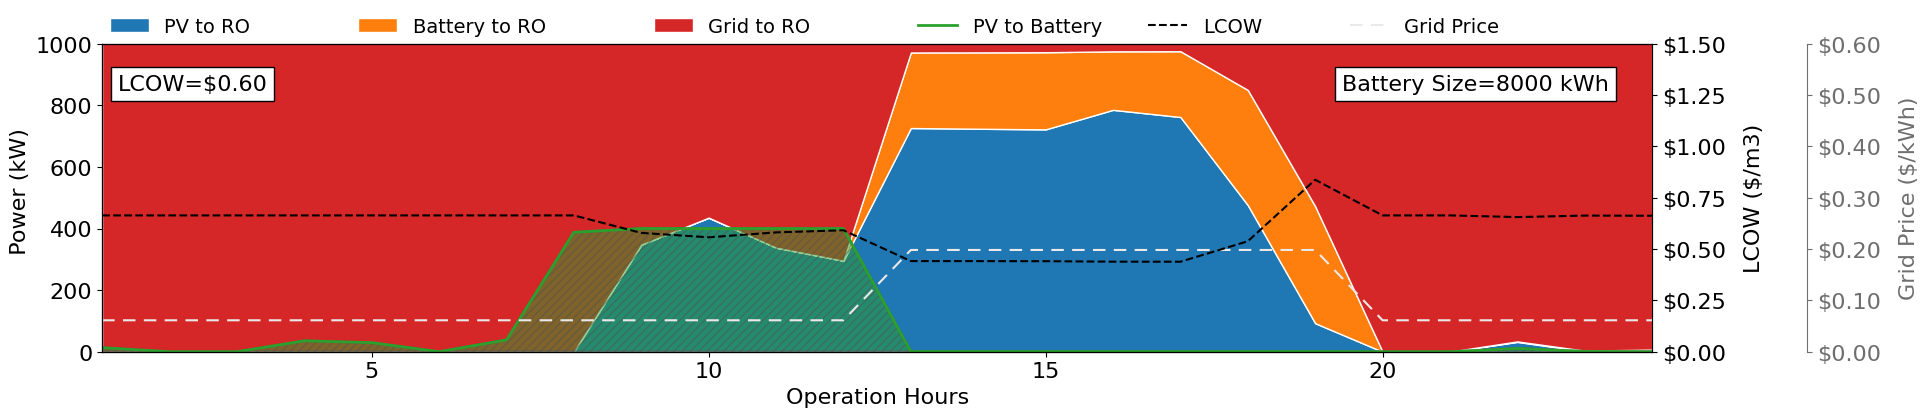

In [15]:
from util.visualize import create_plot
create_plot(mp)